<a href="https://colab.research.google.com/github/jlee1998/Kernel-Flows-for-Irregular-Time-Series/blob/main/Lorenz_New.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import tqdm
import matplotlib.pyplot as plt

In [ ]:
import numpy as np

def VDP(T, dt, N_sims, sigma, rho, random_theta=False):
    N_t  = int(T//dt)
    sims = np.zeros((N_sims, N_t, 2))
    cov  = dt * np.array(
            [[sigma**2,       sigma**2 * rho],
             [sigma**2 * rho, sigma**2]])
    dW   = np.random.multivariate_normal([0, 0], cov, size=(N_sims, N_t))
    for j in range(0,N_sims):
      for i in range(1,N_t):
        sims[j,i,0] = sims[j,(i-1),0] + 100*(sims[j,(i-1),1]-6.75*(sims[j,(i-1),0]+1)*sims[j,(i-1),0]**2)*dt + dW[j,i,0]
        sims[j,i,1] = sims[j,(i-1),1] + (-0.5-sims[j,(i-1),0])*dt + 0.1*dW[j,i,1]


    return sims.astype(np.float32)

def Henon(T, dt, N_sims,a,b):
    N_t  = int(T//dt)
    sims = np.zeros((N_sims, N_t, 2))
    for i in range(1,N_t):
        sims[:, i] = np.array([1-a*sims[:,i-1,0]**2+sims[:,i-1,1],b*sims[:,i-1,0]]).T
    return sims.astype(np.float32)

def Lorenz(T, dt, N_sims,s,r,b):
    N_t  = int(T//dt)
    sims = np.zeros((N_sims, N_t, 3))
    for sim in range(N_sims):
        sims[sim,0,0] = 0.
        sims[sim,0,1] = 1.
        sims[sim,0,2] = 1.05
        for i in range(1,N_t):
            sims[sim, i, 0] = sims[sim,i-1,0] + dt*(s*(sims[sim,i-1,1]-sims[sim,i-1,0]))
            sims[sim, i, 1] = sims[sim,i-1,1] + dt*(r*(sims[sim,i-1,0])-sims[sim,i-1,1] - (sims[sim,i-1,0]*sims[sim,i-1,2]))
            sims[sim, i, 2] = sims[sim,i-1,2] + dt*( -b*(sims[sim,i-1,2]) + (sims[sim,i-1,0]*sims[sim,i-1,1]))

    return sims.astype(np.float32)

def prepare_data(data_x,delay, normalize):
    lenX=data_x.shape[1]
    num_modes = data_x.shape[0]
    
    X=np.zeros((1+lenX-2*delay,delay*num_modes))
    Y=np.zeros((1+lenX-2*delay,delay*num_modes))
    for mode in range(num_modes):
        for i in range(1+lenX-2*delay):
            X[i,(mode*delay):(mode*delay+delay)]=data_x[mode,i:(i+delay)]
            Y[i,(mode*delay):(mode*delay+delay)]=data_x[mode,(i+delay):(i+2*delay)]
    
            
    # Normalize
    X=X/normalize
    Y=Y/normalize
    return X, Y

def prepare_data_fast(data_x, delay, normalize, irregular_delays = None):
    data = data_x.T / normalize
    Y = data[delay:]
    
    #irregular_delays_norm = (irregular_delays-irregular_delays.mean()) / irregular_delays.std()
    if irregular_delays is not None:
        data = np.concatenate((data,irregular_delays[...,None]),-1)
    
    X = np.zeros((data.shape[0]-delay,delay*data.shape[1]))

    for i in range(X.shape[0]):
        X[i] = data[i:(i+delay)].reshape(-1)
    
    return X, Y

def prepare_irregular_data(data_x,delay, normalize, delays):

    assert delay==1 # This is currrently validated for delay 1 only. Extra stuff required to generalize.

    lenX=data_x.shape[1]
    num_modes = data_x.shape[0]
    
    X=np.zeros((1+lenX-2*delay,delay*num_modes))
    Y=np.zeros((1+lenX-2*delay,delay*num_modes))
    for mode in range(num_modes):
        for i in range(1+lenX-2*delay):
            X[i,(mode*delay):(mode*delay+delay)]=data_x[mode,i:(i+delay)]
            Y[i,(mode*delay):(mode*delay+delay)]=data_x[mode,(i+delay):(i+2*delay)]
    
            
    # Normalize
    X=X/normalize
    Y=Y/normalize

    X = np.concatenate((X,delays[...,None][:-1]),-1)

    return X, Y

In [ ]:
import torch
import numpy as np
#%% Kernel operations

# Returns the norm of the pairwise difference
def norm_matrix(matrix_1, matrix_2):
    norm_square_1 = torch.sum(torch.square(matrix_1), axis = 1)
    norm_square_1 = torch.reshape(norm_square_1, (-1,1))
    
    norm_square_2 = torch.sum(torch.square(matrix_2), axis = 1)
    norm_square_2 = torch.reshape(norm_square_2, (-1,1))
    
    d1=matrix_1.shape
    d2=matrix_2.shape
#    print(d1)
#    print(d2)
    if d1[1]!=d2[1]:
        matrix_1=torch.transpose(matrix_1)
    
    inner_matrix = torch.matmul(matrix_1, torch.transpose(matrix_2,0,1))
    
    norm_diff = -2 * inner_matrix + norm_square_1 + torch.transpose(norm_square_2,0,1)
#    print(norm_diff.shape)
    
    return norm_diff



# Returns the pairwise inner product
def inner_matrix(matrix_1, matrix_2):
    d1=matrix_1.shape
    d2=matrix_2.shape
    # print(d1)
    # print(d2)
    if d1[1]!=d2[1]:
        matrix_1=torch.transpose(matrix_1,0,1)
    return torch.matmul(matrix_1, torch.transpose(matrix_2,0,1))

def kernel_anl3(matrix_1, matrix_2, parameters):
    i=0
    
    matrix = norm_matrix(matrix_1, matrix_2)
    sigma = parameters[i+0]
    K =  torch.exp(-matrix/ (2* sigma**2))
    K=K*(parameters[i+1])**2
    i=i+2
    
    
    c = (parameters[i])**2
    imatrix = inner_matrix(matrix_1, matrix_2)
    K = K+ (parameters[i+1])**2 *(imatrix+c) ** 2
    i=i+2
    
    beta = parameters[i]
    gamma = (parameters[i+1])**2
    K=K+ (parameters[i+2])**2 *(beta**2 + gamma*matrix)**(-1/2)
    i=i+3
    
    alpha = parameters[i]
    beta = parameters[i+1]
    K=K+ (parameters[i+2])**2 *(beta**2 + matrix)**(-alpha)
    i=i+3
    
    sigma = parameters[i]
    K=K+ (parameters[i+1])**2 * 1/(1 + matrix/sigma**2)
    i=i+2
    
    alpha_0 = parameters[i]
    sigma_0 = parameters[i+1]
    alpha_1 = parameters[i+2]
    sigma_1 = parameters[i+3]
    K =  K+ (parameters[i+4])**2 *alpha_0*torch.maximum(torch.zeros(1,device = parameters.device), 1-matrix/(sigma_0))+ alpha_1 * torch.exp(-matrix/ (2* sigma_1**2))
    i=i+5
    
    p = parameters[i]
    l = parameters[i+1]
    sigma = parameters[i+2]
    K =K+ (parameters[i+3])**2 * torch.exp(-torch.sin(matrix*np.pi/p)**2/l**2)*torch.exp(-matrix/sigma**2)
    i=i+4
    
    p = parameters[i]
    l = parameters[i+1]
    K = K+ (parameters[i+2])**2 *torch.exp(-torch.sin(matrix*np.pi/p)/l**2)
    i=i+3
    
    return K

In [ ]:
import math
def sample_selection(N, size):
    indices = np.arange(N)
    sample_indices = np.sort(np.random.choice(indices, size, replace= False))
    #sample_indices = indices[:size]
    return sample_indices

# The pi or selection matrix
def pi_matrix(sample_indices, dimension):
    pi = torch.zeros(dimension).double()
    
    for i in range(dimension[0]):
        pi[i][sample_indices[i]] = 1
    
    return pi

def batch_creation(N, batch_size, sample_proportion = 0.5):
    if batch_size == False:
        batch_indices = np.arange(N)
    elif 0 < batch_size <= 1:
        batch_size = int(N * batch_size)
        batch_indices = sample_selection(N, batch_size)
    else:
        batch_indices = sample_selection(N, batch_size)
        
    # Sample from the mini-batch
    sample_size = math.ceil(len(batch_indices)*sample_proportion)
    sample_indices = sample_selection(len(batch_indices), sample_size)
    
    return sample_indices, batch_indices

class KernelFlowsSG(torch.nn.Module):

    def __init__(self, kernel_keyword, nparameters, regu_lambda, dim, metric = "rho_ratio", batch_size = 100, device = torch.device("cpu")):
        super().__init__()
        self.kernel_keyword = kernel_keyword
        
        self.regu_lambda = regu_lambda

        self.kernel_params = torch.nn.Parameter(torch.ones(nparameters),requires_grad = True)
        self.kernel = kernel_anl3

        self.dim = dim

        self.batch_size = batch_size
        self.device = device
        self.metric = metric

        if metric == "rho_ratio":
            self.rho_fun = self.rho_ratio
        elif metric == "rho_general":
            self.rho_fun = self.rho_general
        elif metric == "rho_ratio_k":
            self.rho_fun = self.rho_ratio_k
        else:
            raise("Metric not supported")

    def get_parameters(self):
        return self.kernel_params
    
    def set_train(self, train):
        self.train = train

    def set_training_data(self,X,Y):
        self.X_train = X
        self.Y_train = Y
        self.N = self.X_train.shape[0] # Number of samples
    
    def prepare_semi_group(self,n_z, delays_train):
        
        random_idx = np.random.choice(self.X_train.shape[0]-1,n_z, replace = False)
        random_delays_pre = delays_train[random_idx]
        random_delays_post = delays_train[random_idx+1]

        self.X_train_phi2 = torch.cat((self.X_train[random_idx,:-1],random_delays_pre[...,None]),-1)
        
        self.z_tensor = self.X_train[random_idx+1,:-1] 
        
        self.X_train_phi3_a = torch.cat((self.z_tensor,random_delays_post[...,None]),-1)
        self.X_train_phi3_b = -  torch.cat((self.X_train[random_idx,:-1],random_delays_pre[...,None]+random_delays_post[...,None]),-1)

        self.X_train = ( (self.X_train,self.X_train_phi2,self.X_train_phi3_a), (self.X_train,self.X_train_phi2,self.X_train_phi3_b))
        self.Y_train  = (self.Y_train,self.z_tensor,torch.zeros_like(self.z_tensor))

        self.Nz = n_z # Number of z samples

    def make_kernel_old(self,matrix_data1,matrix_data2,kernel_params, n_1, n_2, n_3, one_sided = False):
        
        K = 0
        if one_sided:
            weights = torch.ones((matrix_data1[0][0].shape[0],n_1+n_2+n_3))
            weights[:,:n_1+n_2] = 0.5
        else:
            weights = torch.ones((n_1+n_2+n_3,n_1+n_2+n_3))
            weights[:n_1+n_2,:n_1+n_2] = 0.5
        assert len(matrix_data1)==len(matrix_data2)
        for i in range(len(matrix_data1)):
            #import ipdb; ipdb.set_trace()
            K = K + weights * self.kernel(torch.cat(matrix_data1[i]),torch.cat(matrix_data2[i]),kernel_params)
        return K
    
    def make_kernel(self,matrix_data1,matrix_data2,kernel_params, n_1, n_2, n_3, one_sided = False):
        

        #Phi0 and 1
        if one_sided:
            N_ = matrix_data1.shape[0]
            K = torch.zeros(N_,(n_1+n_2+n_3), device = kernel_params.device).double()
            K[:,:n_1+n_2] = self.kernel(matrix_data1,torch.cat(matrix_data2[0][:2]),kernel_params)
            K[:,n_1+n_2:] = self.kernel(matrix_data1,matrix_data2[0][2],kernel_params) - self.kernel(matrix_data1,matrix_data2[1][2],kernel_params)

        else:
            K = torch.zeros((n_1+n_2+n_3),(n_1+n_2+n_3), device = kernel_params.device).double()
            K[:n_1+n_2,:n_1+n_2] = self.kernel(torch.cat(matrix_data1[0][:2]),torch.cat(matrix_data2[0][:2]),kernel_params)
            K[:n_1+n_2,n_1+n_2:] = self.kernel(torch.cat(matrix_data1[0][:2]),matrix_data2[0][2],kernel_params) - self.kernel(torch.cat(matrix_data1[0][:2]),matrix_data2[1][2],kernel_params)
            K[n_1+n_2:,:n_1+n_2] = self.kernel(matrix_data1[0][2],torch.cat(matrix_data2[0][:2]),kernel_params) - self.kernel(matrix_data1[1][2],torch.cat(matrix_data2[0][:2]),kernel_params) 
            K[n_1+n_2:,n_1+n_2:] = self.kernel(matrix_data1[0][2],matrix_data2[0][2],kernel_params) - self.kernel(matrix_data1[0][2],matrix_data2[1][2],kernel_params) - self.kernel(matrix_data1[1][2],matrix_data2[0][2],kernel_params) + self.kernel(matrix_data1[1][2],matrix_data2[1][2],kernel_params)
        
        return K
        
    
    def rho_general(self, matrix_data, Y_data,  regu_lambda = 0.000001, ns = None, **kwargs):
        
        kernel_matrix = self.make_kernel(matrix_data,matrix_data, self.kernel_params, ns[0], ns[1], ns[2])

        kernel_matrix = kernel_matrix / torch.trace(kernel_matrix)
        
        inverse_matrix = torch.linalg.inv(kernel_matrix + regu_lambda * torch.eye(kernel_matrix.shape[0]))
        
        rho = torch.tensordot(torch.cat(Y_data), torch.matmul(inverse_matrix, torch.cat(Y_data)))
        
        return rho

    def rho_ratio_k(self, matrix_data, Y_data, sample_indices, sample_indices_z,  regu_lambda = 0.000001, ns = None, k = 1, **kwargs):
        rho_ = 0
        for idx in np.array_split(sample_indices,np.ceil(len(sample_indices)/k)):
            rho_ = rho_ + self.rho_ratio( matrix_data = matrix_data, Y_data = Y_data, sample_indices = np.array([idx]), sample_indices_z = sample_indices_z,  regu_lambda = regu_lambda, ns=ns , **kwargs)
        return rho_ / len(sample_indices)

    def rho_ratio(self, matrix_data, Y_data, sample_indices, sample_indices_z,  regu_lambda = 0.000001, ns = None, device = torch.device("cpu"), **kwargs):
       
        kernel_matrix = self.make_kernel(matrix_data,matrix_data, self.kernel_params, ns[0], ns[1], ns[2])

        sample_indices_ = np.concatenate((sample_indices, sample_indices_z+self.batch_size, sample_indices_z+ self.batch_size + self.batch_size_z))
        N_ = ns[0] + ns[1] +ns[2] 
        pi = pi_matrix(sample_indices_, (sample_indices_.shape[0], N_)).to(self.device) 
    #    print(pi.shape)
        
        sample_matrix = torch.matmul(pi, torch.matmul(kernel_matrix, torch.transpose(pi,0,1)))
    #    print(sample_matrix.shape)
        
        Y_sample = torch.cat(Y_data)[sample_indices_]
    #    print(Y_sample.shape)
        
        inverse_data = torch.linalg.inv(kernel_matrix + regu_lambda * torch.eye(kernel_matrix.shape[0], device = self.device))
        inverse_sample = torch.linalg.inv(sample_matrix + regu_lambda * torch.eye(sample_matrix.shape[0], device = self.device))
    #    print(inverse_sample.shape)
    #    B=np.matmul(inverse_sample, Y_sample)
    #    print(B.shape)
        top = torch.tensordot(Y_sample, torch.matmul(inverse_sample, Y_sample))
        
        bottom = torch.tensordot(torch.cat(Y_data), torch.matmul(inverse_data, torch.cat(Y_data)))
        
        return 1 - top/bottom 

    def forward(self, adaptive_size = False, proportion = 0.5):            
        
        if adaptive_size == False or adaptive_size == "Dynamic":
            sample_size = proportion
        elif adaptive_size == "Linear":
            sample_size_array = sample_size_linear(iterations, adaptive_range) 
        else:
            print("Sample size not recognized")
            
                
        # Create a batch and a sample
        sample_indices, batch_indices = batch_creation(self.N, batch_size= self.batch_size, sample_proportion = sample_size)
        
        batch_size_z = self.Nz #min(self.batch_size,self.Nz)
        self.batch_size_z = batch_size_z
        sample_indices_z, batch_indices_z = batch_creation(self.Nz, batch_size= batch_size_z, sample_proportion = sample_size)

        X_data = tuple( (x[0][batch_indices],x[1][batch_indices_z],x[2][batch_indices_z]) for x in self.X_train)
        Y_data = (self.Y_train[0][batch_indices], self.Y_train[1][batch_indices_z], self.Y_train[2][batch_indices_z])
        
        #optimizer and backward

        rho = self.rho_fun( X_data, Y_data, regu_lambda = self.regu_lambda, ns = (len(batch_indices),batch_size_z,batch_size_z), sample_indices = sample_indices, sample_indices_z = sample_indices_z)
           
        return rho

    def compute_kernel_and_inverse(self,regu_lambda = 0.0000001):
        X_data = self.X_train

        self.kernel_matrix = self.make_kernel(X_data, X_data,self.kernel_params, self.N, self.Nz, self.Nz)
        self.kernel_matrix += regu_lambda * torch.eye(self.kernel_matrix.shape[0], device = X_data[0][0].device)
        
        self.inverse_kernel = torch.linalg.inv(self.kernel_matrix)
        self.A_matrix = torch.matmul(self.inverse_kernel,torch.cat(self.Y_train))

    def predict(self,x_test):
        
        kernel_pred = self.make_kernel(x_test,self.X_train,self.kernel_params, n_1 = self.N, n_2 = self.Nz,  n_3 = self.Nz , one_sided = True)
        prediction = torch.matmul(kernel_pred,self.A_matrix)
        return prediction

    def predict_ahead(self,x_test, horizon, delay, delta_t_mode = False, device = None):
        """
        Perform n=horizon steps ahead prediction.
        If delta_t_mode is True, x_test is expected to have the the following structure (X(t-1),delta_t-1,X(t),delta_t))
        
        out_dim is the dimension of the y vector (and of the observations in x as well)
        delay : delay used in the x
        """
        assert horizon >0 # minimum horizon is 1
        assert delay >0 

        Y_p = torch.zeros((x_test.shape[0],self.dim))
        X_test_ = torch.Tensor(x_test).double().to(device)

        if delta_t_mode:
            indices_delays = [((self.dim+1)*i,(self.dim+1)*i+1) for i in range(delay)] # We should not touch the delta t
        else:
            indices_delays = [(self.dim*i,self.dim*i+1) for i in range(delay)]
        
        # Make sure there is no contamination (deleting the previous values)
        for dim in range(horizon):
            n_delays = min(dim,delay)
            for n in range(1,n_delays+1):
                X_test_[dim::horizon][:,indices_delays[-n]] = 0

        # Predicting and propagating predictions to the next step.
        for dim in range(horizon):
    
            Y_p[dim::horizon] = self.predict(X_test_[dim::horizon])
            
            for dim_plus in range(dim+1,min(horizon,delay+dim+1)):
                
                l_x = X_test_[dim_plus::horizon].shape[0]
                idx = dim_plus-dim

                X_test_[dim_plus::horizon][:,indices_delays[-1*idx][0]:1+indices_delays[-1*idx][1]] = Y_p[dim::horizon][:l_x] # should be -1-2:-1 for irregular

        return Y_p


class KernelFlows(torch.nn.Module):
    
    def __init__(self, kernel_keyword, nparameters, regu_lambda, dim, metric = "rho_ratio", batch_size = 100):
        super().__init__()
        self.kernel_keyword = kernel_keyword
        
        self.regu_lambda = regu_lambda

        self.kernel_params = torch.nn.Parameter(torch.ones(nparameters),requires_grad = True)
        self.kernel = kernel_anl3

        self.dim = dim

        self.batch_size = batch_size

        if metric == "rho_ratio":
            self.rho_fun = self.rho_ratio
        elif metric == "rho_general":
            self.rho_fun = self.rho_general
        else:
            raise("Metric not supported")
        self.metric = metric

    def get_parameters(self):
        return self.kernel_params
    
    def set_train(self, train):
        self.train = train

    def set_training_data(self,X,Y):
        self.X_train = X
        self.Y_train = Y

    def prepare_semi_group(self,n_z, max_delay, device):
        
        random_idx = np.random.choice(self.X_train.shape[0],n_z, replace = False)
        random_delays_pre = torch.Tensor(np.random.randint(max_delay,size=n_z)+1, device = device)
        random_delays_post = torch.Tensor(np.random.randint(max_delay,size=n_z)+1, device = device)

        self.X_train_phi2 = torch.cat((self.X_train[random_idx,:-1],random_delays_pre[...,None]),-1)
        
        self.z_tensor = torch.nn.Parameter(torch.randn(n_z,self.dim),requires_grad = True)

        self.X_train_phi3 = torch.cat((self.z_tensor,random_delays_post[...,None]),-1) -  torch.cat((self.X_train[random_idx,:-1],random_delays_pre[...,None]+random_delays_post[...,None]),-1)

        self.X_train = torch.cat((self.X_train,self.X_train_phi2,self.X_train_phi3))
        self.Y_train  = torch.cat((self.Y_train,self.z_tensor,torch.zeros_like(self.z_tensor, device = device)))

    def prepare_semi_group_new(self,n_z, delays_train):
        
        random_idx = np.random.choice(self.X_train.shape[0]-1,n_z, replace = False)
        random_delays_pre = delays_train[random_idx]
        random_delays_post = delays_train[random_idx+1]

        self.X_train_phi2 = torch.cat((self.X_train[random_idx,:-1],random_delays_pre[...,None]),-1)
        
        self.z_tensor = self.X_train[random_idx+1,:-1] 
        
        self.X_train_phi3 = torch.cat((self.z_tensor,random_delays_post[...,None]),-1) -  torch.cat((self.X_train[random_idx,:-1],random_delays_pre[...,None]+random_delays_post[...,None]),-1)
        #self.X_train_phi3 = torch.cat((self.X_train[random_idx,:-1],random_delays_pre[...,None]+random_delays_post[...,None]),-1)

        self.X_train = torch.cat((self.X_train,self.X_train_phi2,self.X_train_phi3))
        self.Y_train  = torch.cat((self.Y_train,self.z_tensor,torch.zeros_like(self.z_tensor)))

    def prepare_semi_group_simple(self,n_z, delays_train):
        
        random_idx = np.random.choice(self.X_train.shape[0]-2,n_z, replace = False)
        random_delays_pre = delays_train[random_idx]
        random_delays_post = delays_train[random_idx+1]

        self.X_train_phi2 = torch.cat((self.X_train[random_idx,:-1],random_delays_pre[...,None]+random_delays_post[...,None]),-1)
        
        self.z_tensor = self.X_train[random_idx+2,:-1] 
        
        #self.X_train_phi3 = torch.cat((self.X_train[random_idx,:-1],random_delays_pre[...,None]+random_delays_post[...,None]),-1)

        self.X_train = torch.cat((self.X_train,self.X_train_phi2))
        self.Y_train  = torch.cat((self.Y_train,self.z_tensor))

    def rho_ratio(self, matrix_data, Y_data, sample_indices,  regu_lambda = 0.000001):
        self.device = torch.device("cpu")
        kernel_matrix = self.kernel(matrix_data, matrix_data, self.kernel_params)
    #    print(kernel_matrix.shape)
        pi = pi_matrix(sample_indices, (sample_indices.shape[0], matrix_data.shape[0])).to(matrix_data.device) 
    #    print(pi.shape)
        
        sample_matrix = torch.matmul(pi, torch.matmul(kernel_matrix, torch.transpose(pi,0,1)))
    #    print(sample_matrix.shape)
        
        Y_sample = Y_data[sample_indices]
    #    print(Y_sample.shape)
        
        inverse_data = torch.linalg.inv(kernel_matrix + regu_lambda * torch.eye(kernel_matrix.shape[0], device = matrix_data.device))
        inverse_sample = torch.linalg.inv(sample_matrix + regu_lambda * torch.eye(sample_matrix.shape[0], device = self.device))
        top = torch.tensordot(Y_sample, torch.matmul(inverse_sample, Y_sample))
        
        bottom = torch.tensordot(Y_data, torch.matmul(inverse_data, Y_data))
        
        return 1 - top/bottom 
    
    def rho_general(self, matrix_data, Y_data,  regu_lambda = 0.000001, **kwargs):
        
        kernel_matrix = self.kernel(matrix_data, matrix_data, self.kernel_params)

        kernel_matrix = kernel_matrix / torch.trace(kernel_matrix)
        
        inverse_matrix = torch.linalg.inv(kernel_matrix + regu_lambda * torch.eye(kernel_matrix.shape[0]))
        
        rho = torch.tensordot(Y_data, torch.matmul(inverse_matrix, Y_data))
        
        return rho

    def forward(self, adaptive_size = False, proportion = 0.5):            
        
        if adaptive_size == False or adaptive_size == "Dynamic":
            sample_size = proportion
        elif adaptive_size == "Linear":
            sample_size_array = sample_size_linear(iterations, adaptive_range) 
        else:
            print("Sample size not recognized")
            
                
        # Create a batch and a sample
        sample_indices, batch_indices = batch_creation(self.X_train.shape[0], batch_size= self.batch_size, sample_proportion = sample_size)
        X_data = self.X_train[batch_indices]
        Y_data = self.Y_train[batch_indices]
        
        #optimizer and backward

        rho = self.rho_fun( X_data, Y_data, 
                                       sample_indices = sample_indices, regu_lambda = self.regu_lambda)
           
        return rho

    def compute_kernel_and_inverse(self,regu_lambda = 0.0000001):
        X_data = self.X_train
        self.kernel_matrix = self.kernel(X_data,X_data, self.kernel_params)
        self.kernel_matrix += regu_lambda * torch.eye(self.kernel_matrix.shape[0], device = X_data.device)
        
        self.inverse_kernel = torch.linalg.inv(self.kernel_matrix)
        self.A_matrix = torch.matmul(self.inverse_kernel,self.Y_train)

    def predict(self,x_test):
        kernel_pred = self.kernel(x_test,self.X_train,self.kernel_params)
        prediction = torch.matmul(kernel_pred,self.A_matrix)
        return prediction

    def predict_ahead(self,x_test, horizon, delay, delta_t_mode = False, device = torch.device("cpu")):
        """
        Perform n=horizon steps ahead prediction.
        If delta_t_mode is True, x_test is expected to have the the following structure (X(t-1),delta_t-1,X(t),delta_t))
        
        out_dim is the dimension of the y vector (and of the observations in x as well)
        delay : delay used in the x
        """
        assert horizon >0 # minimum horizon is 1
        assert delay >0 

        device = torch.device("cpu")

        Y_p = torch.zeros((x_test.shape[0],self.dim))
        X_test_ = torch.Tensor(x_test).double().to(device)

        if delta_t_mode:
            indices_delays = [((self.dim+1)*i,(self.dim+1)*i+1) for i in range(delay)] # We should not touch the delta t
        else:
            indices_delays = [(self.dim*i,self.dim*i+1) for i in range(delay)]
        
        # Make sure there is no contamination (deleting the previous values)
        for dim in range(horizon):
            n_delays = min(dim,delay)
            for n in range(1,n_delays+1):
                X_test_[dim::horizon][:,indices_delays[-n]] = 0

        # Predicting and propagating predictions to the next step.
        for dim in range(horizon):
    
            Y_p[dim::horizon] = self.predict(X_test_[dim::horizon])
            
            for dim_plus in range(dim+1,min(horizon,delay+dim+1)):
                
                l_x = X_test_[dim_plus::horizon].shape[0]
                idx = dim_plus-dim

                X_test_[dim_plus::horizon][:,indices_delays[-1*idx][0]:2+indices_delays[-1*idx][1]] = Y_p[dim::horizon][:l_x] # should be -1-2:-1 for irregular

        return Y_p

def train_kernel(X_train, Y_train, model,  lr = 0.1, epochs=1000,verbose= False):
    """
    dim is the dimension of a single observation
    """ 
    #model = KernelFlows(kernel_name,nparameters= nparameters, regu_lambda=regu_lambda, dim = dim)
    optimizer = torch.optim.SGD(model.parameters(), lr = lr)

    model.set_training_data(torch.Tensor(X_train).double(),torch.Tensor(Y_train).double())
    rho_list=[]

    for i in tqdm.tqdm(range(epochs)):
        optimizer.zero_grad()
        rho = model.forward()
        rho_list.append(rho.detach().numpy())
        if rho>=0 and rho<=1 and model.metric=="rho_ratio":
            rho.backward()
            optimizer.step()
            if verbose:
                print(rho)
            
    return model, rho_list

# Lorenz

## Regular time steps

# Irregular Sampling


## Data Generation

In [ ]:
max_delay = 5
N_points = 10000
train_n = 5000
burnin = 200
dt = 0.01

delays = np.random.randint(max_delay,size=N_points-1)+1
indices = np.concatenate((np.zeros(1),np.cumsum(delays))).astype(int)
delays = np.concatenate((delays,np.zeros(1))).astype(int)

max_idx = indices[-1]
T = np.ceil(max_idx*dt)

# generate dataset
Data = Lorenz(T=T+burnin*dt, dt=dt,s=10,r=28,b = 10/3, N_sims=1)[0][burnin:]

#times
observed_data = Data[indices]

train_data = observed_data[:train_n,:].T
test_data = observed_data[train_n:,:].T
delays_train = delays[:train_n]
delays_test = delays[train_n:]

## Classical Kernel Flow

In [ ]:
# Some constants
nparameters=24
delay = 2
regu_lambda = 0.00001
lr = 0.01

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = prepare_data_fast(train_data,delay,normalize)
X_test, Y_test = prepare_data_fast(test_data,delay,normalize)

model = KernelFlows("anl3", nparameters = nparameters, regu_lambda = regu_lambda, dim = 3, metric = "rho_ratio", batch_size = 100)

model, rho_list= train_kernel(X_train, Y_train, model, lr = lr,epochs=1000)

100%|██████████| 1000/1000 [00:04<00:00, 217.50it/s]


In [ ]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)

horizon = 20

Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = False)

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()
r2 = 1-mse_pred/Y_test.var()

print(f"MSE On test : {mse_pred:.4f} - R2 : {r2:.4f}")

MSE On test : 0.0188 - R2 : 0.7845


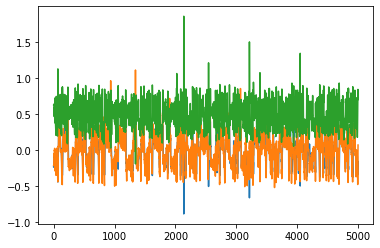

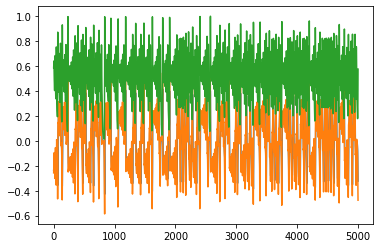

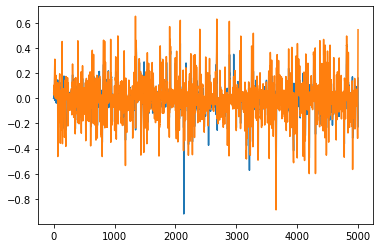

<Figure size 432x288 with 0 Axes>

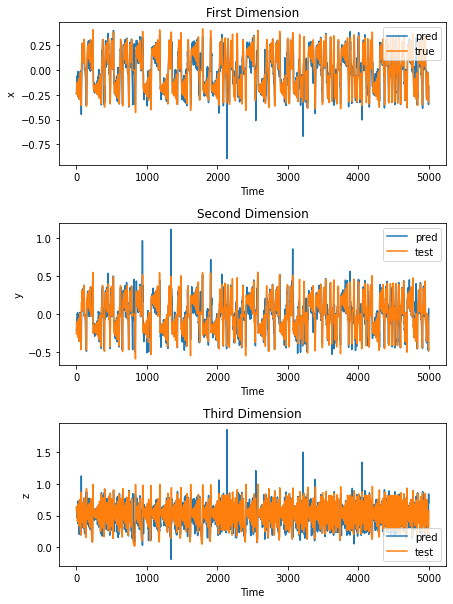

In [ ]:
plt.plot(Y_pred[:,:].detach())
plt.figure()
plt.plot(Y_test[:,:])
plt.figure()
plt.plot(Y_pred[:,0].detach()-Y_test[:,0])
plt.plot(Y_pred[:,1].detach()-Y_test[:,1])
plt.figure()

from pylab import rcParams

fig, ax = plt.subplots(3,1,figsize=(6.4,8.5))
ax[0].plot(Y_pred[:,0].detach(),label = "pred")
ax[0].plot(Y_test[:,0], label = "true")
ax[0].set_xlabel('Time')
ax[0].set_ylabel('x')
ax[0].set_title("First Dimension")
ax[0].legend(loc = "upper right")

ax[1].plot(Y_pred[:,1].detach(),label = "pred")
ax[1].plot(Y_test[:,1], label = "test")
ax[1].set_xlabel('Time')
ax[1].set_ylabel('y')
ax[1].set_title("Second Dimension")
ax[1].legend(loc = "upper right")

ax[2].plot(Y_pred[:,2].detach(),label = "pred")
ax[2].plot(Y_test[:,2], label = "test")
ax[2].set_xlabel('Time')
ax[2].set_ylabel('z')
ax[2].set_title("Third Dimension")
ax[2].legend(loc = "lower right")
fig.tight_layout()
plt.savefig('lorenz3.png')

/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/proj3d.py:189: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/proj3d.py:189: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


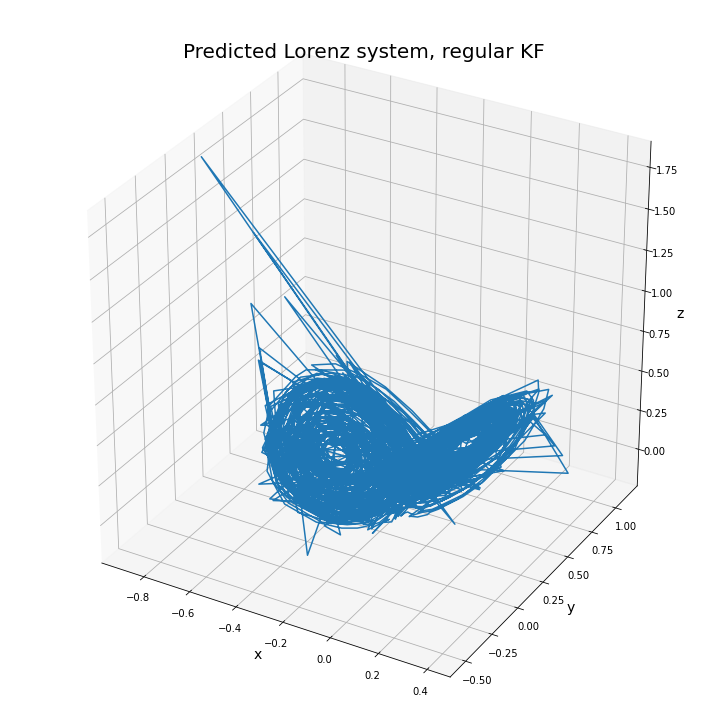

In [ ]:
fig = plt.figure(figsize=(10,10), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')
#ax.plot(Y_test[:,0],Y_test[:,1],Y_test[:,2])
ax.plot(Y_pred[:,0].detach(),Y_pred[:,1].detach(),Y_pred[:,2].detach())
ax.set_xlabel('x',size=14)
ax.set_ylabel('y',size=14)
ax.set_zlabel('z',size=14)
ax.set_title('Predicted Lorenz system, regular KF',fontsize=20)
plt.savefig('lorenz4.png')

## Irregular Kernel Flows

In [ ]:
# Some constants
nparameters=24
delay = 2
regu_lambda = 0.00001
lr = 0.01

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = prepare_data_fast(train_data,delay,normalize, delays_train)
X_test, Y_test = prepare_data_fast(test_data,delay,normalize, delays_test)

model = KernelFlows("anl3", nparameters = nparameters, regu_lambda = regu_lambda, dim = 3, metric = "rho_ratio", batch_size = 100)

model, rho_list = train_kernel(X_train, Y_train, model, lr = lr)

100%|██████████| 1000/1000 [00:09<00:00, 108.99it/s]


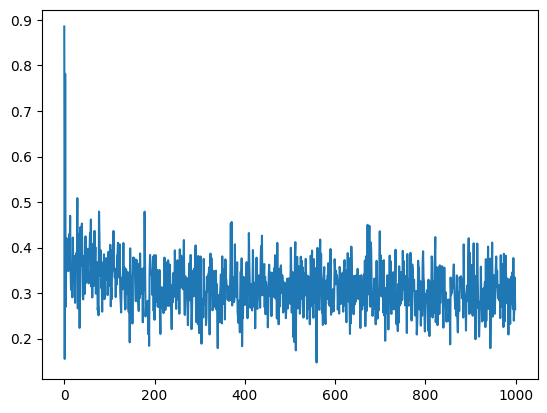

In [ ]:
plt.plot(rho_list)

In [ ]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)

horizon = 20

Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = True)

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()
r2 = 1-mse_pred/Y_test.var()

print(f"MSE On test : {mse_pred:.4f} - R2 : {r2:.4f}")

KeyboardInterrupt: ignored

In [ ]:
plt.plot(Y_pred[:,:].detach())
plt.figure()
plt.plot(Y_test[:,:])
plt.figure()
plt.plot(Y_pred[:,0].detach()-Y_test[:,0])
plt.plot(Y_pred[:,1].detach()-Y_test[:,1])
plt.plot(Y_pred[:,2].detach()-Y_test[:,2])
plt.figure()

fig, ax = plt.subplots(3,1,figsize=(6.4,8.5))
ax[0].plot(Y_pred[:,0].detach(),label = "pred")
ax[0].plot(Y_test[:,0], label = "true")
ax[0].set_title("First Dimension")
ax[0].set_xlabel('Time')
ax[0].set_ylabel('x')
ax[0].legend(loc = "upper right")

ax[1].plot(Y_pred[:,1].detach(),label = "pred")
ax[1].plot(Y_test[:,1], label = "test")
ax[1].set_title("Second Dimension")
ax[1].set_xlabel('Time')
ax[1].set_ylabel('y')
ax[1].legend(loc = "upper right")

ax[2].plot(Y_pred[:,2].detach(),label = "pred")
ax[2].plot(Y_test[:,2], label = "test")
ax[2].set_title("Third Dimension")
ax[2].set_xlabel('Time')
ax[2].set_ylabel('z')
ax[2].legend(loc = "upper right")
fig.tight_layout()
plt.savefig('lorenz5.png')

NameError: ignored

/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/proj3d.py:189: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/proj3d.py:189: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


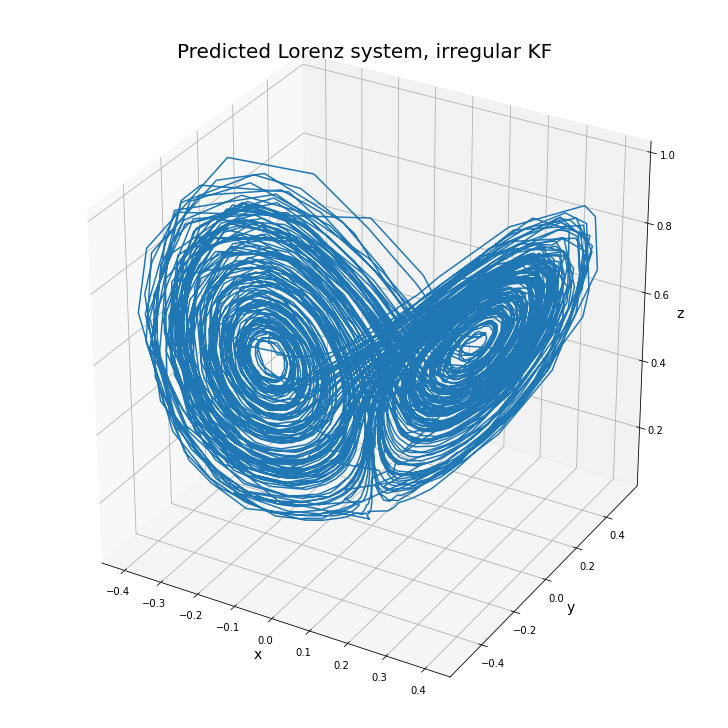

In [ ]:
fig = plt.figure(figsize=(10,10), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')
#ax.plot(Y_test[:,0],Y_test[:,1],Y_test[:,2])
ax.plot(Y_pred[:,0].detach(),Y_pred[:,1].detach(),Y_pred[:,2].detach())
ax.set_xlabel('x',size=14)
ax.set_ylabel('y',size=14)
ax.set_zlabel('z',size=14)
plt.title('Predicted Lorenz system, irregular KF',size=20)
plt.savefig('lorenz6.png')

# new code

In [ ]:
# import numpy as np
# import torch
# import tqdm
# import matplotlib.pyplot as plt
# import time

# def generate_Lorenz_data(alpha):
#     max_delay = alpha
#     N_points = 10000
#     train_n = 5000
#     burnin = 200
#     dt = 0.01

#     delays = np.random.randint(max_delay,size=N_points-1)+1
#     indices = np.concatenate((np.zeros(1),np.cumsum(delays))).astype(int)
#     delays = np.concatenate((delays,np.zeros(1))).astype(int)

#     max_idx = indices[-1]
#     T = np.ceil(max_idx*dt)

#     # generate dataset
#     Data = Lorenz(T=T+burnin*dt, dt=dt,s=10,r=28,b = 10/3, N_sims=1)[0][burnin:]

#     #times
#     observed_data = Data[indices]

#     train_data = observed_data[:train_n,:].T
#     test_data = observed_data[train_n:,:].T
#     delays_train = delays[:train_n]
#     delays_test = delays[train_n:]

#     return train_data, test_data, delays_train, delays_test

# def original_kernel_flow(train_data, test_data, n_parameters, delay, regu_lambda, lr, horizon, dim, epochs = 1000):

#     # Get scaling factor
#     normalize=np.amax(train_data[:,:])

#     X_train, Y_train = prepare_data_fast(train_data,delay,normalize)
#     X_test, Y_test = prepare_data_fast(test_data,delay,normalize)

#     model = KernelFlows("anl3", nparameters = n_parameters, regu_lambda = regu_lambda, dim = dim, metric = "rho_ratio", batch_size = 100)

#     model  = train_kernel(X_train, Y_train, model, lr = lr, epochs = epochs)

#     model.compute_kernel_and_inverse(regu_lambda = regu_lambda)

#     Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = False)

#     mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()
#     r2 = 1-mse_pred/Y_test.var()

#     return mse_pred, r2

# def irregular_kernel_flow(train_data, test_data, delays_train, delays_test, n_parameters, delay, regu_lambda, lr, horizon, dim, epochs = 1000):
#     # Get scaling factor
#     normalize=np.amax(train_data[:,:])

#     X_train, Y_train = prepare_data_fast(train_data,delay,normalize, delays_train)
#     X_test, Y_test = prepare_data_fast(test_data,delay,normalize, delays_test)

#     model = KernelFlows("anl3", nparameters = n_parameters, regu_lambda = regu_lambda, dim = dim, metric = "rho_ratio", batch_size = 100)

#     model  = train_kernel(X_train, Y_train, model, lr = lr, epochs = epochs)
#     model.compute_kernel_and_inverse(regu_lambda = regu_lambda)
#     Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = True)

#     mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()
#     r2 = 1-mse_pred/Y_test.var()

#     return mse_pred, r2

# def derivative_kernel_flow(train_data, test_data, delays_train, delays_test, n_parameters, delay, regu_lambda, lr, horizon, dim, epochs = 1000):
#     # Get scaling factor
#     normalize=np.amax(train_data[:,:])

#     X_train, Y_train = prepare_data_fast(train_data,delay,normalize, derivative_learning = True, irregular_delays = delays_train)
#     X_test, Y_test_ = prepare_data_fast(test_data,delay,normalize, derivative_learning = True, irregular_delays = delays_test)
#     _, Y_test = prepare_data_fast(test_data,delay,normalize)
#     model = KernelFlows("anl3", nparameters = n_parameters, regu_lambda = regu_lambda, dim = dim, metric = "rho_ratio", batch_size = 100)
 
#     model  = train_kernel(X_train, Y_train, model, lr = lr, epochs = epochs)
#     model.compute_kernel_and_inverse(regu_lambda = regu_lambda)
#     #Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = True)
#     Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = False, derivative_learning = True, delta_t = delays_test[:-delay])

#     mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()
#     r2 = 1-mse_pred/Y_test.var()

#     return mse_pred, r2



# def LorenzExp(learning = True,alpha = 5, exp_flags = {"o":True,"i":True,"d":True}, horizon = 20, epochs = 1000, lr = 0.01):
#     num_repeats = 5
#     train_data, test_data, delays_train, delays_test = generate_Lorenz_data(alpha)

#     if learning is False:
#         epochs = 0
#     else:
#         epochs = epochs

#     regu_lambda = 0.00001
#     horizon = horizon
#     delay = 2
#     lr = lr
#     dim = 3
    
#     start_time = time.time()
#     run_all_exps(train_data, test_data, delays_train, delays_test, regu_lambda, horizon, delay, lr, dim, num_repeats, epochs, exp_flags = exp_flags)
#     end_time = time.time()
#     elapsed_time = end_time - start_time
#     print(f"Computation time: {elapsed_time/num_repeats}")
    
    
# def run_all_exps(train_data, test_data, delays_train, delays_test, regu_lambda, horizon, delay, lr, dim, num_repeats, epochs , exp_flags = {"o":True,"i":False,"d":False}):
#     mse_o = []
#     r2_o = []
#     mse_i = []
#     r2_i = []
#     mse_d = []
#     r2_d = []
#     for rep in range(num_repeats):
#         if exp_flags["o"]:
#             mse_pred_o, r2_pred_o = original_kernel_flow(train_data,test_data,n_parameters=24, delay = delay, regu_lambda = regu_lambda, lr = lr, horizon = horizon, dim = dim, epochs = epochs)
#             mse_o.append(mse_pred_o)
#             r2_o.append(r2_pred_o)
#         if exp_flags["i"]:
#             mse_pred_i, r2_pred_i = irregular_kernel_flow(train_data,test_data, delays_train, delays_test, n_parameters=24, delay = delay, regu_lambda = regu_lambda, lr =lr, horizon = horizon, dim = dim, epochs = epochs)
#             r2_i.append(r2_pred_i)
#             mse_i.append(mse_pred_i)
#         if exp_flags["d"]:
#             mse_pred_d, r2_pred_d = derivative_kernel_flow(train_data,test_data, delays_train, delays_test, n_parameters=24, delay = delay, regu_lambda = regu_lambda, lr = lr, horizon = horizon, dim = dim, epochs = epochs)
#             mse_d.append(mse_pred_d)
#             r2_d.append(r2_pred_d)
   
#     mse_o = np.array(mse_o)
#     mse_i = np.array(mse_i)
#     mse_d = np.array(mse_d)
#     r2_o  = np.array(r2_o)
#     r2_i  = np.array(r2_i)
#     r2_d  = np.array(r2_d)
    
#     print(f"Original : {np.nanmean(mse_o):.4f} +- {np.nanstd(mse_o):.4f} -- R2 {np.nanmean(r2_o):.4f} +- {np.nanstd(r2_o):.4f}")
#     print(f"Irregular : {np.nanmean(mse_i):.4f} +- {np.nanstd(mse_i):.4f} -- R2 {np.nanmean(r2_i):.4f} +- {np.nanstd(r2_i):.4f}")
#     print(f"Derivative : {np.nanmean(mse_d):.4f} +- {np.nanstd(mse_d):.4f} -- R2 {np.nanmean(r2_d):.4f} +- {np.nanstd(r2_d):.4f}")


    
# if __name__=="__main__":
  
#     alpha = 5
#     horizon = 20
#     epochs = 1000
#     #HenonExp(learning = True,alpha = 4, exp_flags = {"o":False,"i":True,"d":False})
#     for lr in [0.001]:#,30,40,50]:
#         print(lr)
#         LorenzExp(learning = True, alpha = alpha, exp_flags = {"o":True,"i":False,"d":False}, horizon = horizon, epochs = epochs, lr = lr )
#         #VDPExp(learning = True, alpha = alpha, exp_flags = {"o":True,"i":False,"d":False} ) 